n- 机器学习项目主要步骤：
1. 放眼大局
2. 获取数据
3. 探索和可视化数据以获取见解
4. 为机器学习算法准备数据
5. 选择一个模型并训练它
6. 微调模型
7. 展示解决方案
8. 发布，监控和维护系统

## 放眼大局
利用加州的一份住房与人口统计数据来构建房价预测模型。数据中汇总了各个最小统计单元的指标，如人口数量、家庭收入中位数、房价中位数等。这里我们把这些最小统计单元统称为“地区” （一个地区通常有600-3000人）。你的模型需要基于这些特征学习，在给定其他指标的情况下预测任一地区的房价中位数。

拿出你的机器学习项目清单， 对于多数机器学习项目，它可以工作得很好；但确保根据需求进行调整。

### 框定问题

你问老板的第一个问题应该是业务目标到底是什么。建立模型可能不是最终目标。公司期望如何使用该模型并从中受益？了解目标很重要，因为它将决定你如何框定问题、你将选择哪些算法、你将使用哪种性能指标来评估你的模型，以及你将花费多少精力来调整它。

老板回答说，你的模型的输出（对一个地区房价中位数的预测）将连同许多其他信息一起输入到另一个机器学习系统（见下图）。这个下游系统将决定在给定的区域是否值得投资。做到这一点至关重要，因为它直接影响收入。

![机器学习流水线](./images/end_to_end_ml_proj/p1.png)

- 流水线：

系列数据处理组件称为数据流水线。流水线在机器学习系统中非常常见，因为有大量数据需要操作并且需要应用很多的数据转换。

组件通常是异步运行的。每个组件都会拉取大量数据，对其进行处理，然后将结果输出到另一个数据存储器中。然后，一段时间后，流水线中的下一个组件拉取此数据并给出自己的输出。每个组件都是相当独立的：组件之间的接口就是数据存储。这使得系统易于掌握（借助于数据流图），不同的团队可以专注于不同的组件。此外，如果一个组件发生故障，下游组件通常可以仅使用损坏组件的最后输出继续正常运行（至少一段时间）。这使得架构非常健壮。

另外，如果没有实施适当的监控，损坏的组件可能会在一段时间内被忽视。数据变得陈旧，整个系统的性能会下降。


- 在开始训练机器学习系统之前，请你先思考并尝试回答以下问题：

<details>
<summary> 你认为这是什么类型的机器学习任务？</summary>

**这是一个监督学习任务**。
因为我们拥有带有标签的数据：每条记录都包括模型的输入（如人口、收入中位数等）和目标输出（该地区的房价中位数）。模型可以利用这些已标注的样本进行训练。

</details>

<details>
<summary> 它是分类任务还是回归任务？</summary>

**这是一个回归任务**，因为我们希望预测的是一个连续数值（即房价中位数），而不是分类标签。

进一步来说，这是一个 **单预测值回归** 问题：我们只预测一个输出值。
不过，它也是一个 **多元回归**（multiple regression）问题，因为我们使用多个输入特征来预测这个输出值。

</details>

<details>
<summary>应该使用批量学习还是在线学习？</summary>

**推荐使用批量学习（Batch Learning）**。

原因如下：
- 数据集大小适中，足以完全载入内存。
- 没有实时数据流不断涌入系统。
- 环境相对稳定，不需要模型频繁调整以应对数据分布漂移。

因此，传统的批量学习方法即可胜任，不需要在线学习技术。

如果数据量很大，可以将批量学习的工作拆分到多个服务器，或者使用在线学习技术
</details>


### 选择性能指标

下一步是选择性能指标。回归问题的典型性能度量是均方根误差(Root Mean Square Error，RMSE)。它给出了系统在其预测中通常会产生多大误差，并为较大的误差赋予较高的权重

- RMSE 公式及符号说明

我们使用下列公式来计算预测结果的均方根误差（Root Mean Square Error, RMSE）：

$$
\text{RMSE}(X, h) = \sqrt{ \frac{1}{m} \sum_{i=1}^{m} \left(h\left(x^{(i)}\right) - y^{(i)} \right)^2 }
$$



- 符号说明

这个公式引入了几个在机器学习中非常常见的符号，以下是各个符号的含义：

- **m** 是你测量 RMSE 的数据集中的**实例数**。
  例如，如果你在 2000 个地区的验证集上评估 RMSE，则有：
  `m = 2000`

- **x⁽ⁱ⁾** 是数据集中第 *i* 个实例的所有**特征值**（不包括标签）的向量，
  **y⁽ⁱ⁾** 是它的**标签**（该实例的期望输出值）。

  例如，如果数据集中的第一个地区位于经度 -118.29°，纬度 33.91°，居住有 1416 人，收入中位数为 38372 美元，房屋价值中位数为 156400 美元（暂时忽略其他特征），那么：

  $$
  x^{(1)} = \begin{bmatrix}
  -118.29 \\
  33.91 \\
  1416 \\
  38372
  \end{bmatrix}
  \quad \text{和} \quad
  y^{(1)} = 156400
  $$

- **X** 是一个矩阵，包含数据集中所有实例的所有特征值（不包括标签）。
  每个实例为一行，第 *i* 行等于 \(x^{(i)}\) 的转置，记作 $$(x^{(i)})^T$$

表示特征矩阵 **X**：

$$
X =
\begin{pmatrix}
(x^{(1)})^\mathrm{T} \\
(x^{(2)})^\mathrm{T} \\
\vdots \\
(x^{(1999)})^\mathrm{T} \\
(x^{(2000)})^\mathrm{T}
\end{pmatrix}
=
\begin{pmatrix}
-118.29 & 33.91 & 1416 & 38372 \\
\vdots & \vdots & \vdots & \vdots
\end{pmatrix}
$$

- **h** 是系统的**预测函数**，也称为假设。
  当给系统一个实例的特征向量 $ x^{(i)} $ 时，它会输出该实例的预测值：

  $$
  \hat{y}^{(i)} = h(x^{(i)})
  $$

---

- 平均绝对误差（MAE）

$$
\text{MAE}(X, h) = \frac{1}{m} \sum_{i=1}^{m} \left| h(x^{(i)}) - y^{(i)} \right|
$$

RMSE 和 MAE 都是衡量两个向量（预测向量和目标向量）之间距离的方法。各种距离度量或范数是可能的：

- 计算平方和的根（RMSE）对应于欧几里得范数：这是我们都熟悉的距离概念。
  它也被称为 $\ell_2$ 范数，记为 $\| \cdot \|_2$（或简写为 $\| \cdot \|$）。

- 计算绝对值之和（MAE）对应于 $\ell_1$ 范数，记为 $\| \cdot \|_1$。
  这有时被称为曼哈顿范数，因为如果你只能沿着正交的城市街区行动，那么它会测量城市中两点之间的距离。

- 一般而言，包含 $n$ 个元素的向量 $v$ 的 $\ell_k$ 范数定义为：

$$
\|v\|_k = (|v_1|^k + |v_2|^k + \cdots + |v_n|^k)^{1/k}
$$

- $\ell_0$ 给出向量中的非零元素的数量，$\ell_\infty$ 给出向量中的最大绝对值。


范数指数越高，它就越关注**大值**而忽略小值。这就是 RMSE 比 MAE 对异常值更敏感的原因。

但是当异常值呈指数级减少时（例如在钟形曲线中），RMSE 表现非常好，并且通常是首选。



### 检查假设

最后，**列出并验证已有假设**是非常重要的一步，有助于及早发现潜在问题。
例如，你假设系统输出的房价将被下游系统原样使用。但如果下游其实将其转化为“便宜”“中等”“昂贵”等类别并用于分类模型，那你当前的回归建模将毫无意义。

因此，**在明确需求之前，不应盲目假设问题类型**。幸运的是，在与下游团队沟通后，你确认他们确实需要实际价格值。


## 获取数据


In [2]:
import sys

assert sys.version_info >= (3, 7)   # 检查python版本

from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")  # 检查sklearn版本

In [3]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

调用load_housing_data()时，它会查找datasets/housing.tgz文件。如果找不到，它会在当前目录中创建datasets目录，从ageron/data GitHub存储库下载housing.tgz文件，并将其内容提取到datasets目录中。这将创建datasets/housing目录，其中包含housing.csv文件。最后，该函数将此CSV文件加载到包含所有数据的Pandas DataFrame对象中，并返回它。

In [4]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


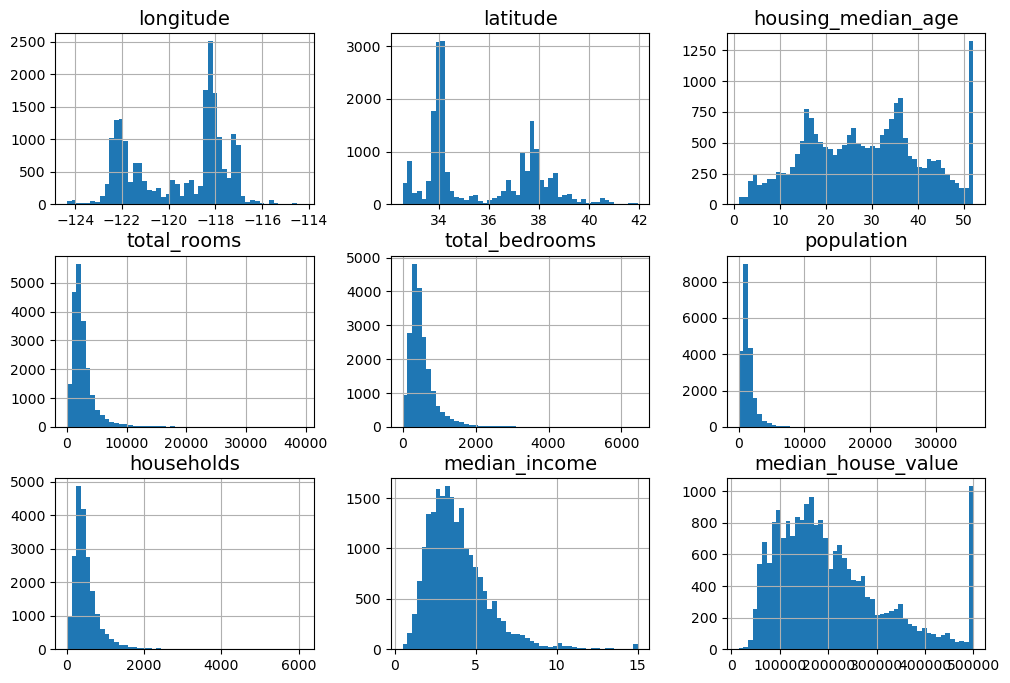

In [8]:
import matplotlib.pyplot as plt

# 定义默认字体大小
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

housing.hist(bins=50, figsize=(12, 8))
plt.show()

### 创建测试集

In [9]:
import numpy as np

def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [10]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)
len(train_set)

16512

In [11]:
len(test_set)

4128

上述实现的弊端：数据更新后，或者反复多次运行分离训练和测试数据后，还是会看到整个数据集

解决方案：通过标识符来决定它是否应该进入测试集（假设实例的标识符是唯一且不变的）。比如，可以计算每个实例标识符的哈希值，如果哈希值低于或等于最大哈希值的20%，则将该实例放入测试集中。这可以确保测试集在多次运行中保持一致，即使刷新数据集也是如此。

In [13]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * (2**32)

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [14]:
housing_with_id = housing.reset_index()  # 加一个索引列
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

In [15]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]  # 通过经纬度创建id
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

Scikit-Learn提供了一些函数以各种方式将数据集拆分为多个子集。最简单的函数是train_test_split()，它所做的事情与我们之前定义的shuffle_and_split_data()函数几乎相同，

但有几个附加功能。首先，有一个random_state参数允许你设置随机生成器种子，保证在数据不变的前提下，训练和测试的拆分是一致的。

其次，你可以将多个具有相同行数的数据集传递给它，并且它会在相同的索引上拆分它们（这非常有用，例如，如果你有一个单独标签的DataFrame）

In [16]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

- 分层采样：
数据集足够大，纯随机采样没问题。但如果不够大，会引入显著采样偏差。

向1000个人做问卷调查，尝试保证1000个人足够代表全体人口。例如人口中女性占51.1%， 男性占48.9%，因此对1000个人问卷调查尝试保证这样一个比例：511名女性和489名男性，这个就是分层采样。

定义：将总体分为称做层的同质子组，并从每个层中抽取正确数量的实例以保证测试集能代表总体。

如果进行调查的人使用纯随机采样，则大约有10.7%的机会会抽取到女性参与者少于48.5%或超过53.5%的偏差测试集，可以因为采样偏差，得到错误的结论

In [28]:
# 利用二项分布 N次独立随机实验，每次结果为1的概率为p，x次为1的概率 （x<=N)

from scipy.stats import binom
sample_size = 1000
ratio_female = 0.511
proba_too_small = binom(sample_size, ratio_female).cdf(485 - 1)
proba_too_large = 1 - binom(sample_size, ratio_female).cdf(535)
print(proba_too_small + proba_too_large)

0.10736798530929942


In [30]:
# 纯数值模拟采样偏差的概率
samples = (np.random.rand(100_000, sample_size) < ratio_female).sum(axis=1)
((samples < 485) | (samples > 535)).mean()

0.10626

In [17]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

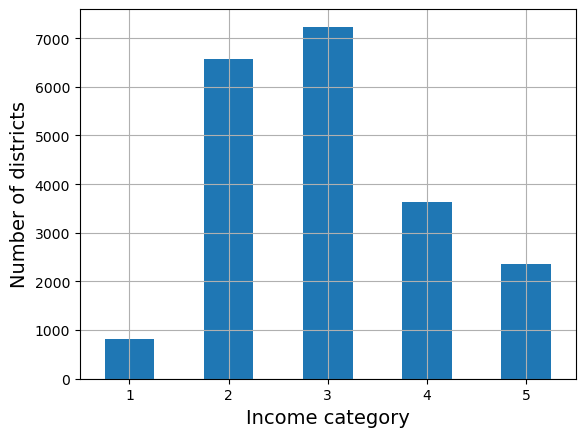

In [18]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

In [19]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

In [20]:
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)  # 分层采样 单词拆分

In [21]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [25]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(housing),
    "Stratified %": income_cat_proportions(strat_test_set),
    "Random %": income_cat_proportions(test_set),
}).sort_index()
compare_props.index.name = "Income Category"
compare_props["Strat. Error %"] = (compare_props["Stratified %"] /
                                   compare_props["Overall %"] - 1)
compare_props["Rand. Error %"] = (compare_props["Random %"] /
                                  compare_props["Overall %"] - 1)
(compare_props * 100).round(2)

,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Income Category,,,,,
1,3.98,4.00,4.24,0.36,6.45
2,31.88,31.88,30.74,-0.02,-3.59
3,35.06,35.05,34.52,-0.01,-1.53
4,17.63,17.64,18.41,0.03,4.42
5,11.44,11.43,12.09,-0.08,5.63


In [27]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)